##  Bayesian approach for the rating model

### References

Some references for this analysis and some interesting readings

[Bayesian star rating approach](https://towardsdatascience.com/bayesian-ranking-system-77818e63b57b)
[Bayesian product decision](https://rpubs.com/pteridin/694049)

[A Bayesian view of Amazon Resellers](https://www.johndcook.com/blog/2011/09/27/bayesian-amazon/)

[WilsonScore](https://www.evanmiller.org/how-not-to-sort-by-average-rating.html)

[Bayesian Estimator](https://medium.com/district-data-labs/computing-a-bayesian-estimate-of-star-rating-means-651496a890ab)

[Aritmetic vs Bayesian average](https://www.codementor.io/@arpitbhayani/solving-an-age-old-problem-using-bayesian-average-15fy4ww08p)

[Bayesian Average 1](https://www.algolia.com/doc/guides/solutions/ecommerce/search-relevance/tutorials/bayesian-average/)
[Bayesian Average 2](https://www.evanmiller.org/bayesian-average-ratings.html)
[Bayesian average 3](https://fulmicoton.com/posts/bayesian_rating/)



### Section1: Binary system (up-down)

We can use the Bayesian statistics to build a ranking system. 
Let's start with a basic example of binary output:
a product ranking website where users vote up/down on a product. 


Simple ranking schemes like percentage of positive votes or up minus down votes perform poorly.
Example:

* $\textrm{Percentage}$: 60 up : 40 down — vs — 6 up : 4 down are both 60 $\%$
* $\textrm{v}$: 100 up : 95 down vs 5 up : 0 down are both +5

Those approaches don't take into consideration that there’s much more data on one than the other.
A Bayesian view of the problem naturally incorporates the amount of data as well as its average.


What we would like is for more votes to add more information: 60 votes hold more information than 6 votes. Let's use the votes as likelihoods in Bayesian inference. 

Here’s a set of movies A-E with up/down votes:

| product id  | up  | down  |  
|---|---|---|
| A  | 60  | 40  | 
| B  |  6 |  1 |
| C  |  6 |  4 | 
| D  |  1 |  2 | 
| E  |  10 | 20  |

and considering the general expression obtained in chapter 3 for the posterior with prior distribution given by a Beta function which is:

$$
f(\theta| y) \sim Beta(\alpha+\sum y_i, \beta+n-\sum y_i)
$$

we can obtain a posterior probability that the product will be voted as good or not. To do that, we need to define a prior beta distribution. 

To choose a prior distribution, we need to do some hypothesis. Remember from the theory that we can always check the effect of this hypotesis in the posterior and build a predictive interval. 

### Choises for the Prio

There are some choises for the choise of the prio based on our prio knowledge and hypotesis:

* We really don't know what would be the distribution of the votes ($\textrm{Hyp 1}$)

* We know that average product are more common than extremely good or extremely bad product. We’d prefer a ranking which started with an assumption of average product and required evidence to move to the extremes  ($\textrm{Hyp 2}$)

* The product manager is preatty confident that all the product will receive good valuation ($\textrm{Hyp 3}$)

#### Hypothesis 1
In this case, a choise is the non informative prio. We opt for a non informative prio with uniform distribution: Beta(1,1)

#### Hypothesis 2
In this case, we want a prio distribution with a peack to the average of the vote so $\alpha= \beta >1$ 
Remember that for a distribution of $ X \sim Beta(\alpha,\beta)  $ the average and standard distribution are respectively:

$$E[X] = \frac{\alpha}{\alpha +\beta} $$

$$Var(X)= \frac{\alpha \beta}{(\alpha +\beta)^2 (\alpha +\beta+1)} $$

If $\alpha=\beta$ the $E[X]=0.5$ and the $Var(X)= \frac{1}{4(2 \alpha +1)}$. The greater is the value of $\alpha$, the lower will be the dispersion around the mean.

For example let's try the shape of a Beta(11,11)

#### Hypothesis 3
In this case we want a distribution peaked around the max vote (in the binary case is 1, in a 5 star system, would be 5). Again we can control the distribution of the prio by playing with the parameters $\alpha$ and $\beta$ but let's try a prio with a Beta(20,1).


Next plot shows the three distribution described:


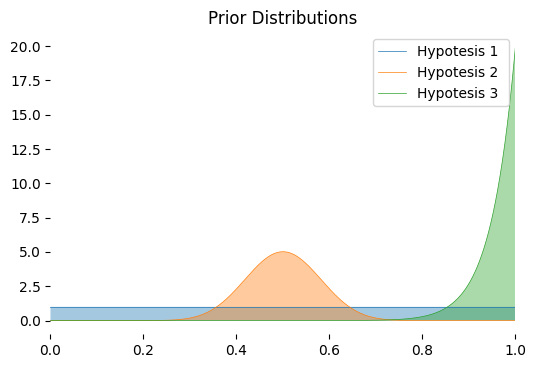

In [19]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

plt.figure(dpi = 100)
axes = plt.gca(frameon=False)

x = np.linspace(0, 1, 1001)
b1 = beta.pdf(x, 1, 1)
p = axes.plot(x, b1, linewidth=0.5)
p[0].set_label("Hypotesis 1 " )
axes.fill_between(x, b1, alpha=0.4)

b2 = beta.pdf(x, 20, 20)
p = axes.plot(x, b2, linewidth=0.5)
p[0].set_label("Hypotesis 2 " )
axes.fill_between(x, b2, alpha=0.4)

b3 = beta.pdf(x, 20, 1)
p = axes.plot(x, b3, linewidth=0.5)
p[0].set_label("Hypotesis 3 " )
axes.fill_between(x, b3, alpha=0.4)

axes.set_xlim(0., 1.)
plt.title("Prior Distributions")
plt.legend()


### Posterior distributions

With the previous prior,let's see how the posteriors look like considering the general formulation recalled in the introduction. 
Moreover, since the beta distribution is a PDF  we’ll need   to convert to a scalar for ranking. One way is to find the minimum value of the beta distribution such that we are 95% confident the true value is greater.

#### Posterior from  Prio 1
| product id  | up  | down  |   Posterior  |
|---|---|---|---|
| A  | 60  | 40  | Beta(61,41) | 
| B  |  6 |  1 | Beta(7,2)| 
| C  |  6 |  4 | Beta(7,5) | 
| D  |  1 |  2 | Beta(2,3) | 
| E  |  10 | 20  | Beta(11,21) | 


Next block show the posterior distribution and also the lower bound of the $95 \%$ confidence interval.

A  60:40 rank: 0.52
B  6:1 rank: 0.53
C  6:4 rank: 0.35
D  1:2 rank: 0.10
E  10:20 rank: 0.21


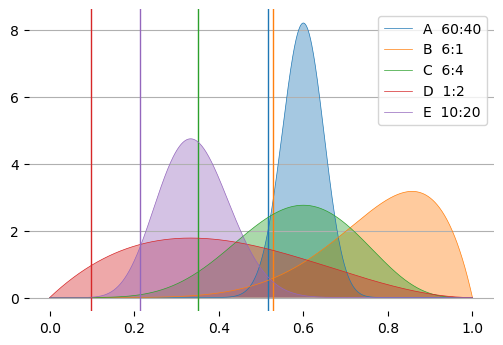

In [8]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

movies_arr = [
        ['A', 60, 40],
        ['B', 6, 1],
        ['C', 6, 4],
        ['D', 1, 2],
        ['E', 10, 20],
               ];

movies= [dict(zip(['name','up','down'], a)) for a in movies_arr]

x = np.linspace(0, 1, 1001)

plt.figure(dpi = 100)
axes = plt.gca(frameon=False)


# Prior information, movies tend to be more average and less extreme
a0, b0 = (1,1)

for i in range(len(movies)):
    a = movies[i]['up'] + a0
    b = movies[i]['down'] + a0
    b1 = beta.pdf(x, a, b)

    p = axes.plot(x, b1, linewidth=0.5)
    p[0].set_label(f"{movies[i]['name']}  {movies[i]['up']}:{movies[i]['down']}" )
    axes.fill_between(x, b1, alpha=0.4)

    rank = beta.ppf(0.05, a, b)
    axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)

    print(f"{movies[i]['name']}  {movies[i]['up']}:{movies[i]['down']} rank: {rank:0.2f}")

axes.grid(b=None, which='major', axis='y')

if a0 > 5:
    axes.set_xlim(0., 1)

plt.legend()


This separates the high evidence A (60:40) and low evidence C (6:4) movies but isn’t an ideal ranking overall, particularly for D (red) which has very little evidence yet receives the worst ranking. 

#### Posterior from  Prio 2
| product id  | up  | down  |   Posterior  |
|---|---|---|---|
| A  | 60  | 40  | Beta(71,51) | 
| B  |  6 |  1 | Beta(17,12)| 
| C  |  6 |  4 | Beta(17,15) | 
| D  |  1 |  2 | Beta(12,13) | 
| E  |  10 | 20  | Beta(21,31) |



A  60:40 rank: 0.51
B  6:1 rank: 0.43
C  6:4 rank: 0.39
D  1:2 rank: 0.32
E  10:20 rank: 0.30


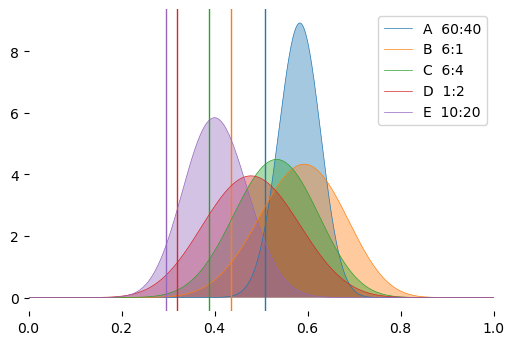

In [19]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

movies_arr = [
        ['A', 60, 40],
        ['B', 6, 1],
        ['C', 6, 4],
        ['D', 1, 2],
        ['E', 10, 20],
               ];

movies= [dict(zip(['name','up','down'], a)) for a in movies_arr]

x = np.linspace(0, 1, 1001)

plt.figure(dpi = 100)
axes = plt.gca(frameon=False)


# Prior information, movies tend to be more average and less extreme
a0, b0 = (11,11)

for i in range(len(movies)):
    a = movies[i]['up'] + a0
    b = movies[i]['down'] + a0
    b1 = beta.pdf(x, a, b)

    p = axes.plot(x, b1, linewidth=0.5)
    p[0].set_label(f"{movies[i]['name']}  {movies[i]['up']}:{movies[i]['down']}" )
    axes.fill_between(x, b1, alpha=0.4)

    rank = beta.ppf(0.05, a, b)
    axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)

    print(f"{movies[i]['name']}  {movies[i]['up']}:{movies[i]['down']} rank: {rank:0.2f}")


if a0 > 5:
    axes.set_xlim(0., 1)

plt.legend()


Result is showing that the low evidence D curve is roughly in the middle while the E curve with significantly more negative evidence now has the lowest rank

#### Posterior from  Prio 3

| product id  | up  | down  |   Posterior  |
|---|---|---|---|
| A  | 60  | 40  | Beta(80,41) | 
| B  |  6 |  1 | Beta(26,2)| 
| C  |  6 |  4 | Beta(26,5) | 
| D  |  1 |  2 | Beta(21,3) | 
| E  |  10 | 20  | Beta(30,21) |


A  60:40 rank: 0.50
B  6:1 rank: 0.43
C  6:4 rank: 0.40
D  1:2 rank: 0.36
E  10:20 rank: 0.33


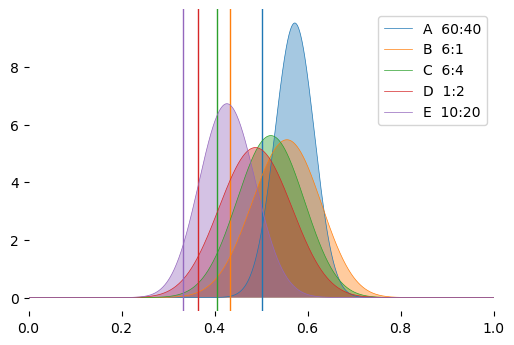

In [20]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

movies_arr = [
        ['A', 60, 40],
        ['B', 6, 1],
        ['C', 6, 4],
        ['D', 1, 2],
        ['E', 10, 20],
               ];

movies= [dict(zip(['name','up','down'], a)) for a in movies_arr]

x = np.linspace(0, 1, 1001)

plt.figure(dpi = 100)
axes = plt.gca(frameon=False)


# Prior information, movies tend to be more average and less extreme
a0, b0 = (20,1)

for i in range(len(movies)):
    a = movies[i]['up'] + a0
    b = movies[i]['down'] + a0
    b1 = beta.pdf(x, a, b)

    p = axes.plot(x, b1, linewidth=0.5)
    p[0].set_label(f"{movies[i]['name']}  {movies[i]['up']}:{movies[i]['down']}" )
    axes.fill_between(x, b1, alpha=0.4)

    rank = beta.ppf(0.05, a, b)
    axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)

    print(f"{movies[i]['name']}  {movies[i]['up']}:{movies[i]['down']} rank: {rank:0.2f}")


if a0 > 5:
    axes.set_xlim(0., 1)

plt.legend()


### Section2: From binary to multirating 

We can complicate the binary system of up-down votes to a 5 star system by rating each star with a different weigth like below: 

Stars (1,2,3,4,5): up (0,0.25,0.5,0.75,1) down (1,0.75,0.5,0.25,0).

In other words:
For each:

- '*' (one star) we sum the up with 0 (up=up+0), we sum the down with 1 (down=down+1)
- '**' (two stars) we sum the up with 0.25 (up=up+0.25), we sum the down with 0.75 (down=down+0.75)
- '***' (three stars) we sum the up with 0.5 (up=up+0.5), we sum the down with 0.5 (down=down+0.5)
- '****' (four stars) we sum the up with 0.75 (up=up+0.75), we sum the down with 0.25 (down=down+0.25)
- '*****' (five stars) we sum the up with 1 (up=up+1), we sum the down with 0.  (down=down+0.)


For example: we want to compare 2 products
* product 1: received 6 * 5-stars reviews
* product 2: received 20 * 4-stars reviews and 5 * 5-stars reviews

Applying the scaling above to reconduct to a bynary system of two levels of up and down values:

* product 1: Up= 6 * 1=6 , Down =0 * 5=0
* product 2: Up= 20 * 0.75 + 5 * 1=20 , Down = 20 * 0.25+5 * 0=5

Let's start with the prior centred on average value 3:

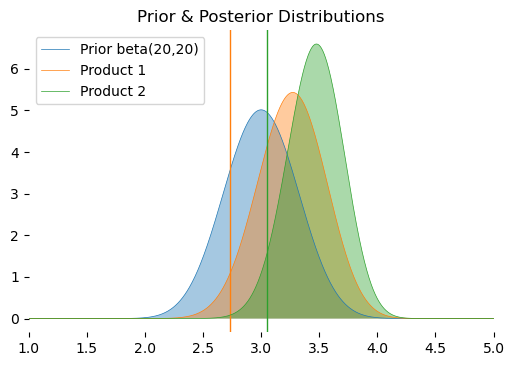

In [112]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

plt.figure(dpi = 100)
axes = plt.gca(frameon=False)

x = np.linspace(0,1, 1001)
b1 = beta.pdf(x, 20,20)
p = axes.plot(x*4+1, b1, linewidth=0.5) #note: to shift for 0-1 to 1-5 we multiplied by the factor *4+1 the x
p[0].set_label("Prior beta(20,20)" )
axes.fill_between(x*4+1, b1, alpha=0.4)

b2 = beta.pdf(x, 26,20)
p = axes.plot(x*4+1, b2, linewidth=0.5)
p[0].set_label("Product 1" )
axes.fill_between(x*4+1, b2, alpha=0.4)
rank = beta.ppf(0.05, 26,21)*4+1
axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)



b3 = beta.pdf(x, 40,25)
p = axes.plot(x*4+1, b3, linewidth=0.5)
p[0].set_label("Product 2" )
axes.fill_between(x*4+1, b3, alpha=0.4)
rank = beta.ppf(0.05, 41,26)*4+1
axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)

axes.set_xlim(1., 5.)
plt.title("Prior & Posterior Distributions")
plt.legend()


As we can see from the previous graph, starting with the prior centrated on the average, the posterior of product 2 is greater than the product 1 and also the rating based on the  lower bound of the  95%  predictive interval

Let's try what is the output starting from the prior uniform distribution:

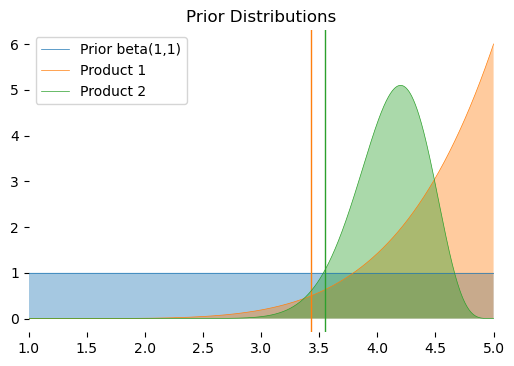

In [50]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

plt.figure(dpi = 100)
axes = plt.gca(frameon=False)

x = np.linspace(0,1, 1001)
b1 = beta.pdf(x, 1, 1)
p = axes.plot(x*4+1, b1, linewidth=0.5)
p[0].set_label("Prior beta(1,1)" )
axes.fill_between(x*4+1, b1, alpha=0.4)

b2 = beta.pdf(x, 6,1)
p = axes.plot(x*4+1, b2, linewidth=0.5)
p[0].set_label("Product 1" )
axes.fill_between(x*4+1, b2, alpha=0.4)
rank = beta.ppf(0.05, 6,1)*4+1
axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)

b3 = beta.pdf(x, 21,6)
p = axes.plot(x*4+1, b3, linewidth=0.5)
p[0].set_label("Product 2" )
axes.fill_between(x*4+1, b3, alpha=0.4)
rank = beta.ppf(0.05, 21,6)*4+1
axes.axvline(x=rank, ymin=0, ymax=1, color=p[0].get_color(), linewidth=1)

axes.set_xlim(1.,5.)
plt.title("Prior & Posterior Distributions")
plt.legend()


In this case the posterior of product 1 seems to be higher than the posterior of product 2. However it has also a long tail, this impact the lower bound for the 95% of the predictive level that also in this case is higher for the product 2. 

With both choises of the prior, the product 2 will have a higher rating than the product 1.



```{admonition} **Important**


One great insight that we can extract from the bayesian approach, differently from the frequentist approach, is not only to know if a variant is better with respect the other and the predictive interval of this, but also to quantify how much a product is better than the other ( or better: the probability than a product A will receive higher evaluations respect to the product B). 


Think to AB test: would be great to monitor daily the Probability that a version A is better than version B and compute the loss by proceeding the test rather just simply waiting that the pvalue is enough to determine the end of the test?


```

In the next section we will compute the joint probability between the posterior of product 1 and product 2 and see how much the product 2 is greater than product 1:

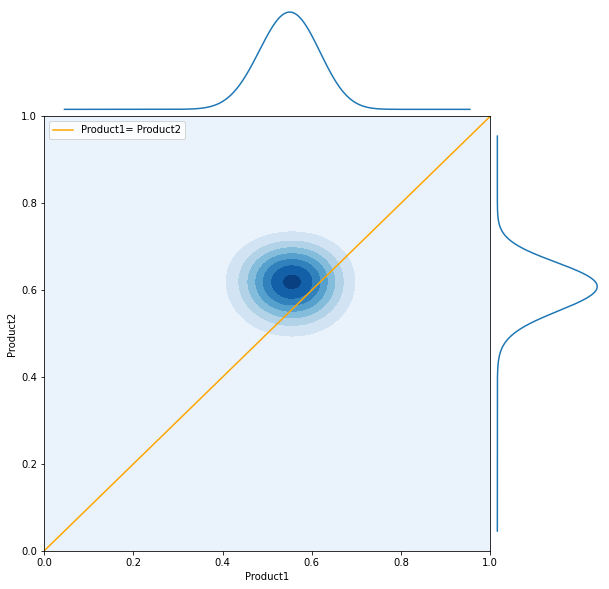

In [123]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def jointplot():
    """Tool function to create a 3 part grid plot."""
    f = plt.figure(figsize=(10,10))
    gs0 = gridspec.GridSpec(5, 5, figure=f, wspace=.02, hspace=.02)
    ax1 = f.add_subplot(gs0[1:, :-1])
    ax2 = f.add_subplot(gs0[:1, :-1])
    ax3 = f.add_subplot(gs0[1:, -1:])
    return ax1, ax2, ax3

a_1, b_1 = (26,21)
a_2, b_2 = (40,25)

a, b = (20,20)

x = pd.Series(np.linspace(0,1,1000))
y = stats.beta.pdf(x, a, b)
x_min, x_max = (0, 1)

y_1 = stats.beta.pdf(x, a_1, b_1)
y_2 = stats.beta.pdf(x, a_2, b_2)

X, Y = np.meshgrid(y_1, y_2)
Z = X * Y

# PLOT
ax1, ax2, ax3 = jointplot()

ax1.contourf(x, x, Z, cmap= 'Blues')
ax1.plot(x, x, color = 'orange', label = 'Product1= Product2')
ax2.plot(x, y_1)
ax3.plot(y_2, x)

ax1.set_xlabel('Product1')
ax1.set_ylabel('Product2')

ax3.set_axis_off()
ax2.set_axis_off()

ax1.legend()
plt.show()

We can see that the posterior of product 2 is higher than the posterior of product 1. All the area above the orange line represents how much the two posteriors are different. Let's quantify this area:

In [124]:
#compute the area above the orange line by mean of monte carlo random sampling
N = 100000

mean_1, var_1 = stats.beta.stats(a_1, b_1, moments='mv')
mean_2, var_2 = stats.beta.stats(a_2, b_2, moments='mv')

randx_1 = np.random.normal(mean_1, 1.25*np.sqrt(var_1), size=N)
randx_2 = np.random.normal(mean_2, 1.25*np.sqrt(var_2), size=N)

y_1 = stats.beta.pdf(randx_1, a_1, b_1)
y_2 = stats.beta.pdf(randx_2, a_2, b_2)

g_1 = stats.norm.pdf(randx_1, mean_1, 1.25*np.sqrt(var_1))
g_2 = stats.norm.pdf(randx_2, mean_2, 1.25*np.sqrt(var_2))

z = (y_1 * y_2) / (g_1 * g_2)

b_better_a_x = randx_1 <= randx_2
b_better_a_z = z[b_better_a_x]

print(f'Integral value:  {1*b_better_a_z.sum()/N}')
print(f'Calculation error: {np.sqrt(1*(b_better_a_z*b_better_a_z).sum()/N - (1*b_better_a_z.sum()/N)**2)/np.sqrt(N)}')




Integral value:  0.7465938930073059
Calculation error: 0.0018369675823056207


The previous results show that there is 75$\%$ of proability that the product 2 will be better evaluated than the product 2. 


Remember: Choose your prior according to your knowledge! It can affect the outcome.

And furthermore: You could miss out on some really great new products with the disadvantage of being new and not properly reviewed. Choose your own risk you want to take, maybe it is okay for you to be wrong 20% of the time?

### Section3: The real case: rating for the buyers and sellers

Let's replicate the previous approach for a real case of dataset coming from the rating received by buyers and sellers during a timeframe of almost 1 month and half.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter

from IPython.display import display
import json

%matplotlib inline

In [6]:
data=pd.read_json('../../datasets-toys/datasets/rating_per_user.json', lines=True)

In [7]:
data.head()


,ratingType,ratings,ratings_date,nof_reviews
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24


In [8]:
data.describe()

,nof_reviews
count,206396.000000
mean,1.038431
std,0.435590
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,86.000000


In [9]:
data['Number_of_date']=data.ratings_date.apply(lambda x: len(set(x)) )

data['Number_of_5']=data.ratings.apply(lambda x: x.count(5) )
data['Number_of_4']=data.ratings.apply(lambda x: x.count(4) )
data['Number_of_3']=data.ratings.apply(lambda x: x.count(3) )
data['Number_of_2']=data.ratings.apply(lambda x: x.count(2) )
data['Number_of_1']=data.ratings.apply(lambda x: x.count(1) )

data.head()

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,15,86,0,0,0,0
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,19,85,0,0,0,0
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29,13,29,0,0,0,0
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28,11,28,0,0,0,0
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24,7,24,0,0,0,0


In [10]:
data['average_star']= (data['Number_of_5']*5+data['Number_of_4']*4+
                       data['Number_of_3']*3+data['Number_of_2']*2+data['Number_of_1']*1)/data['nof_reviews']
data.head()

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,15,86,0,0,0,0,5.0
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,19,85,0,0,0,0,5.0
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29,13,29,0,0,0,0,5.0
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28,11,28,0,0,0,0,5.0
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24,7,24,0,0,0,0,5.0


In [11]:
data['average_star'].value_counts()


5.000000    196005
4.000000      6117
1.000000      2299
3.000000      1413
2.000000       489
4.500000        40
3.500000         9
4.666667         7
2.500000         3
4.333333         3
3.666667         3
1.666667         2
1.500000         1
1.250000         1
2.333333         1
4.833333         1
2.800000         1
4.555556         1
Name: average_star, dtype: int64

In [12]:
def func_sum(group):
    sum_group = group.shape[0]
    return pd.Series([sum_group],
                     index=['sum_group'])

df_overview=data.groupby('ratingType').apply(func_sum).reset_index()

df_overview['ratio%']=(df_overview['sum_group']/data.shape[0] *100).round(2)
df_overview

,ratingType,sum_group,ratio%
0,BuyerToSeller,81844,39.65
1,SellerToBuyer,124552,60.35


Let's start by a classification given by the average of ratings splitting the two cathegories:


#### Group buyer and seller and classifies by mean of average


In [13]:
Sellers= data.loc[data['ratingType']=='BuyerToSeller']
display(Sellers.sort_values([ 'average_star'], ascending=[False]).head(10))

display(Sellers.loc[Sellers['nof_reviews']==Sellers.nof_reviews.max()])

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,19,85,0,0,0,0,5.0
136004,BuyerToSeller,[5.0],[2021-01-30],1,1,1,0,0,0,0,5.0
136012,BuyerToSeller,[5.0],[2021-01-03],1,1,1,0,0,0,0,5.0
136011,BuyerToSeller,[5.0],[2021-01-06],1,1,1,0,0,0,0,5.0
136009,BuyerToSeller,[5.0],[2021-01-06],1,1,1,0,0,0,0,5.0
136008,BuyerToSeller,[5.0],[2021-01-09],1,1,1,0,0,0,0,5.0
136007,BuyerToSeller,[5.0],[2021-01-08],1,1,1,0,0,0,0,5.0
136006,BuyerToSeller,[5.0],[2021-02-01],1,1,1,0,0,0,0,5.0
136005,BuyerToSeller,[5.0],[2021-01-07],1,1,1,0,0,0,0,5.0
136003,BuyerToSeller,[5.0],[2021-01-25],1,1,1,0,0,0,0,5.0


,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,19,85,0,0,0,0,5.0


In [14]:
Bayers= data.loc[data['ratingType']=='SellerToBuyer']
display(Bayers.sort_values(['average_star'], ascending=[False]).head(10))

display(Bayers.loc[Bayers['nof_reviews']==Bayers.nof_reviews.max()])

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,15,86,0,0,0,0,5.0
135754,SellerToBuyer,[5.0],[2021-01-17],1,1,1,0,0,0,0,5.0
135766,SellerToBuyer,[5.0],[2021-02-07],1,1,1,0,0,0,0,5.0
135765,SellerToBuyer,[5.0],[2021-01-15],1,1,1,0,0,0,0,5.0
135764,SellerToBuyer,[5.0],[2021-01-11],1,1,1,0,0,0,0,5.0
135763,SellerToBuyer,[5.0],[2021-02-11],1,1,1,0,0,0,0,5.0
135762,SellerToBuyer,[5.0],[2021-02-05],1,1,1,0,0,0,0,5.0
135761,SellerToBuyer,[5.0],[2021-01-22],1,1,1,0,0,0,0,5.0
135760,SellerToBuyer,[5.0],[2021-01-27],1,1,1,0,0,0,0,5.0
135759,SellerToBuyer,[5.0],[2021-01-09],1,1,1,0,0,0,0,5.0


,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,15,86,0,0,0,0,5.0



It is quickly apparent that there is a problem with our current approach. Reviews with high average ratings but very few reviewers are listed first.

In order to get a feel for our data, let’s visually compare the mean rating to the counts.

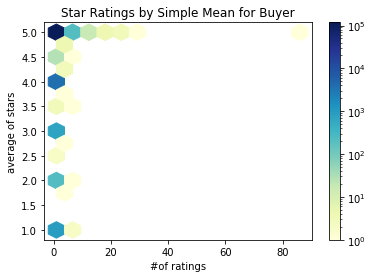

In [15]:
def plot_mean_frequency(df):
    df.plot(x='nof_reviews', y='average_star', kind='hexbin',
                   cmap='YlGnBu',bins='log', gridsize=15, mincnt=1,
                  title="Star Ratings by Simple Mean for Buyer", sharex=False)
    plt.xlabel('#of ratings')
    plt.ylabel('average of stars')
    
plot_mean_frequency(data.loc[data['ratingType']=='SellerToBuyer'])


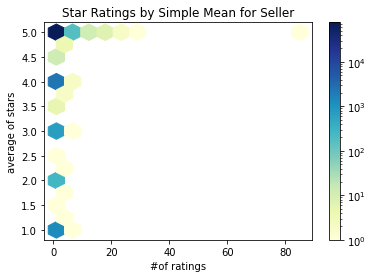

In [16]:
def plot_mean_frequency(df):
    df.plot(x='nof_reviews', y='average_star', kind='hexbin',
                   cmap='YlGnBu',bins='log', gridsize=15, mincnt=1,
                  title="Star Ratings by Simple Mean for Seller", sharex=False)
    plt.xlabel('#of ratings')
    plt.ylabel('average of stars')
    
plot_mean_frequency(data.loc[data['ratingType']=='BuyerToSeller'])

This figure shows that the average rating of a movie is actually slightly higher than 3. There is a strong cluster of Buyer and Seller with less than 10 reviewers whose simple mean rating surrounds 3.5. This contrasts with the rigth side of the figure, where you can clearly see that the mean is 5 when there are more reviewers.
The figure visually calls our attention to a problem. When there are less than 10 reviewers, there are dramatic tails that ensure equally high and low reviews. If there are less than 10 reviews, the probability is much higher that a Buyer/Seller will have an average rating of 1.0, whereas after 10 reviews, the figure shows that it is extremely unlikely to see a movie with an average rating different from 5.
We can hypothesize two things from this plot that allow us to make decisions for our specific data set. First, we become confident that a mean rating is good so long as it has more than 10 reviews. Secondly, we know that the average review is around overall 4. Using these two hypotheses, we can come up with a rule that will allow us to rank seller/buyer according to both the mean rating the movie has received as well as the number of reviewers that have reviewed it and can help to choise a prior distribution.

### Bayesian rating

In [17]:
# let's compute 
#the up and down vote with the scaling:
#up (0,0.25,0.5,0.75,1) down (1,0.75,0.5,0.25,0)
    
data['Up_vote']=data['Number_of_1']*0+data['Number_of_2']*0.25+data['Number_of_3']*0.5+data['Number_of_4']*0.75+data['Number_of_5']*1
data['Down_vote']=data['Number_of_1']*1+data['Number_of_2']*0.75+data['Number_of_3']*0.5+data['Number_of_4']*0.25+data['Number_of_5']*0

data.head()

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star,Up_vote,Down_vote
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,15,86,0,0,0,0,5.0,86.0,0.0
1,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-09, 2021-01-09, 2021-01-09, 2021-01-0...",85,19,85,0,0,0,0,5.0,85.0,0.0
2,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-01, 2021-01-01, 2021-01-20, 2021-01-2...",29,13,29,0,0,0,0,5.0,29.0,0.0
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28,11,28,0,0,0,0,5.0,28.0,0.0
4,BuyerToSeller,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-22, 2021-01-22, 2021-01-22, 2021-01-2...",24,7,24,0,0,0,0,5.0,24.0,0.0


In [20]:
#computing the lower 95%
data['rank']=beta.ppf(0.05, data['Up_vote']+11,data['Down_vote']+11)*4+1

In [21]:
buyer=data.loc[data['ratingType']=='SellerToBuyer'].sort_values('rank', ascending=False) 

In [22]:
buyer.head(100)

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star,Up_vote,Down_vote,rank
0,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-27, 2021-01-13, 2021-01-13, 2021-02-0...",86,15,86,0,0,0,0,5.0,86.0,0.0,4.386527
3,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-31, 2021-01-31, 2021-01-31, 2021-01-1...",28,11,28,0,0,0,0,5.0,28.0,0.0,3.713831
5,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-28, 2021-01-19, 2021-01-19, 2021-01-1...",24,8,24,0,0,0,0,5.0,24.0,0.0,3.609086
7,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-25, 2021-02-08, 2021-02-08, 2021-01-2...",23,12,23,0,0,0,0,5.0,23.0,0.0,3.580205
8,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2021-01-10, 2021-01-19, 2021-01-15, 2021-01-1...",22,7,22,0,0,0,0,5.0,22.0,0.0,3.550112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[2021-01-28, 2021-01-28, 2021-01-27, 2021-01-2...",6,2,6,0,0,0,0,5.0,6.0,0.0,2.813439
148,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[2021-01-08, 2021-01-08, 2021-01-08, 2021-01-0...",6,3,6,0,0,0,0,5.0,6.0,0.0,2.813439
149,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[2021-01-11, 2021-01-11, 2021-01-11, 2021-01-1...",6,1,6,0,0,0,0,5.0,6.0,0.0,2.813439
146,SellerToBuyer,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[2021-02-01, 2021-01-03, 2021-01-03, 2021-01-0...",6,3,6,0,0,0,0,5.0,6.0,0.0,2.813439


In [23]:
seller=data.loc[data['ratingType']=='BuyerToSeller'].sort_values('rank', ascending=False) 

In [24]:
seller.tail(200)

,ratingType,ratings,ratings_date,nof_reviews,Number_of_date,Number_of_5,Number_of_4,Number_of_3,Number_of_2,Number_of_1,average_star,Up_vote,Down_vote,rank
169625,BuyerToSeller,[1.0],[2021-02-08],1,1,0,0,0,0,1,1.00,0.00,1.00,2.245054
67646,BuyerToSeller,[1.0],[2021-01-11],1,1,0,0,0,0,1,1.00,0.00,1.00,2.245054
199610,BuyerToSeller,[1.0],[2021-01-19],1,1,0,0,0,0,1,1.00,0.00,1.00,2.245054
26597,BuyerToSeller,[1.0],[2021-01-22],1,1,0,0,0,0,1,1.00,0.00,1.00,2.245054
67654,BuyerToSeller,[1.0],[2021-01-24],1,1,0,0,0,0,1,1.00,0.00,1.00,2.245054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4451,BuyerToSeller,"[1.0, 1.0]","[2021-01-06, 2021-01-05]",2,2,0,0,0,0,2,1.00,0.00,2.00,2.184374
4994,BuyerToSeller,"[1.0, 1.0]","[2021-01-09, 2021-01-09]",2,1,0,0,0,0,2,1.00,0.00,2.00,2.184374
4220,BuyerToSeller,"[1.0, 1.0]","[2021-01-25, 2021-01-25]",2,1,0,0,0,0,2,1.00,0.00,2.00,2.184374
277,BuyerToSeller,"[2.0, 1.0, 1.0, 1.0]","[2021-01-20, 2021-01-21, 2021-01-21, 2021-01-21]",4,2,0,0,0,1,3,1.25,0.25,3.75,2.114316


At this point we have for both the group a rank based not only on the avarage value but also on the amount of data obtained. 

Following the principle of Bayesian statistics, as soon as new data comes in, we can incorporate it in the model and update our belief.

### Question: Is the overall score of Buyers different from the Sellers ones? Are more critical the Buyers or the Sellers?

Let's compute the overall posterior distribution of the buyers and the sellers

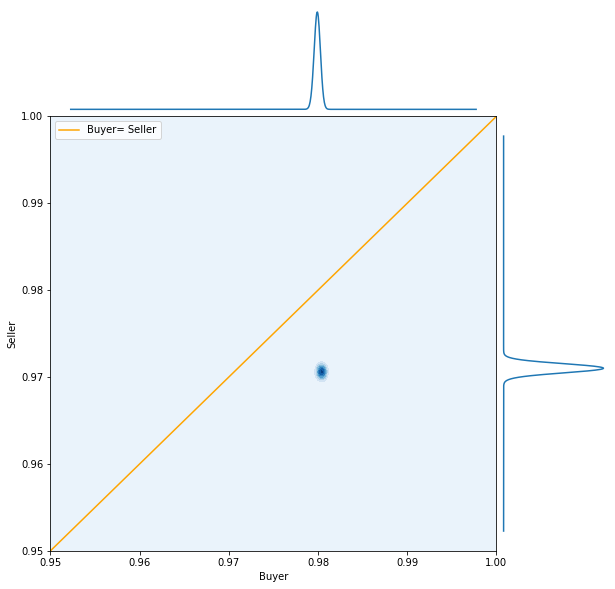

In [47]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def jointplot():
    """Tool function to create a 3 part grid plot."""
    f = plt.figure(figsize=(10,10))
    gs0 = gridspec.GridSpec(5, 5, figure=f, wspace=.02, hspace=.02)
    ax1 = f.add_subplot(gs0[1:, :-1])
    ax2 = f.add_subplot(gs0[:1, :-1])
    ax3 = f.add_subplot(gs0[1:, -1:])
    return ax1, ax2, ax3


a, b = (1,1)
a_1, b_1 = (buyer.Up_vote.sum()+1,buyer.Down_vote.sum()+1)
a_2, b_2 = (seller.Up_vote.sum()+1,seller.Down_vote.sum()+1)

x = pd.Series(np.linspace(0.95,1,1000))
y = stats.beta.pdf(x, a, b)
x_min, x_max = (0.95, 1)

y_1 = stats.beta.pdf(x, a_1, b_1)
y_2 = stats.beta.pdf(x, a_2, b_2)

X, Y = np.meshgrid(y_1, y_2)
Z = X * Y

# PLOT
ax1, ax2, ax3 = jointplot()

ax1.contourf(x, x, Z, cmap= 'Blues')
ax1.plot(x, x, color = 'orange', label = 'Buyer= Seller')
ax2.plot(x, y_1)
ax3.plot(y_2, x)

ax1.set_xlabel('Buyer')
ax1.set_ylabel('Seller')

ax3.set_axis_off()
ax2.set_axis_off()

ax1.legend()
plt.show()

Both the posteriors are shifted toward the high probability, however The Buyers have a highest probability meaning  that the buyers have received the highest votes 